<a href="https://colab.research.google.com/github/zernabhussain/music-mood-recognition-system-CNN/blob/main/ACIAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt     
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPool1D, MaxPool2D ,MaxPooling1D, Dropout, Flatten, Dense, Activation, BatchNormalization 
from sklearn.preprocessing import  MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split 
encoder = OneHotEncoder() 
min_max_scaler = MinMaxScaler()

In [ ]:
def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"])) 
    print('='*20)
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [ ]:
def prepare_datasets(x,y,test_size, validation_size):  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size) 
 
    x_train = x_train[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]

    return x_train, x_validation, x_test, y_train, y_validation, y_test

Totel Number of rows:  686
Totel number of columns:  13
The different type of mood labels:


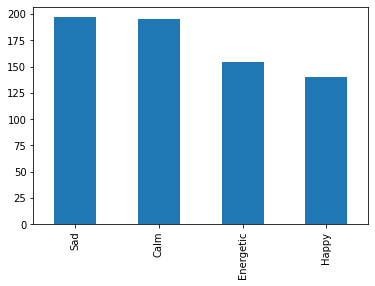

In [ ]:
try:
    norm_data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSOvWjNVMFfGPVlHQ3a1EXSKI118Hf0VNQzJKCBmCNoB8wViLWH7FGJZ8kENu88qolTCnI3Bx_NIEU5/pub?gid=3210966&single=true&output=csv" 
    df = pd.read_csv(norm_data_url, sep=',')   
    print("Totel Number of rows: ",len(df))  
    print('Totel number of columns: ', df.shape[1])  
    print('The different type of mood labels:')
    df.mood.value_counts().plot(kind='bar') 
except:
    print('Error downloading')
    raise
       

In [ ]:
label_ind = {'Happy': 0, 'Sad': 1, 'Energetic': 2, 'Calm': 3}
ind_label = {0: 'Happy', 1: 'Sad', 2: 'Energetic', 3: 'Calm'} 
df.mood = [label_ind[l] for l in df.mood]

main_features = df[['popularity', 'loudness','tempo', 'key', 'time_signature']].values
 
features_scaled = min_max_scaler.fit_transform(main_features) 
scaled_data = pd.DataFrame(features_scaled)

df.popularity = scaled_data[0]
df.loudness = scaled_data[1]
df.tempo = scaled_data[2]
df.key = scaled_data[3]
df.time_signature = scaled_data[4]

In [ ]:
y = df['mood'].values
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray() 
 
x_columns = df.columns.drop(['mood'])
x = df[x_columns].values
 
x_train, x_validation, x_test, y_train, y_validation, y_test  = prepare_datasets(x, y, 0.15, 0.15)

x_train.shape, x_validation.shape, x_test.shape, y_train.shape, y_validation.shape, y_test.shape

((495, 12, 1), (88, 12, 1), (103, 12, 1), (495, 4), (88, 4), (103, 4))

In [ ]:
def build_CNN_model(input_shape): 
    model = Sequential() 

    model.add(Conv1D(32, 3, activation = "relu", input_shape = input_shape)) 
    model.add(MaxPooling1D(pool_size=3, strides=1, padding="same"))
    model.add(BatchNormalization())  

    model.add(Conv1D(32, 3, activation = "relu")) 
    model.add(MaxPooling1D(pool_size=3, strides=1, padding="same"))
    model.add(BatchNormalization())  

    model.add(Conv1D(32, 2, activation = "relu" )) 
    model.add(MaxPooling1D(pool_size=2, strides=1, padding="same"))
    model.add(BatchNormalization())  

    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    
    model.add(Dense(y.shape[1], activation="softmax"))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer = optimizer, 
              loss="MSE", 
              metrics=["accuracy"]) 
    model.summary()

    return model

In [ ]:
input_shape = x_train.shape[1:] 
modelCNN = build_CNN_model(input_shape)
historyCNN = modelCNN.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size=90, epochs=150)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 32)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 32)             3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 32)            0         
 1D)                                                             
                                                        

Predicting:
3/3 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.7961
CNN Evaluation score: [0.06953985244035721, 0.7961165308952332]
Max. Validation Accuracy 0.8522727489471436


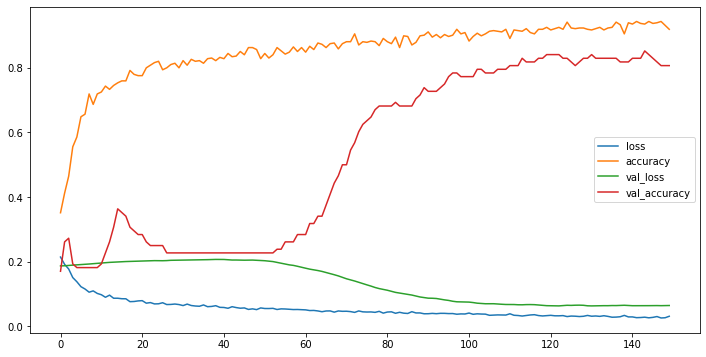

In [ ]:
print('Predicting:') 
escoreCNN = modelCNN.evaluate(x_test, y_test, batch_size=50)
predCNN = modelCNN.predict(x_test)
predCNN = np.argmax(predCNN,axis=1) 
  
print("CNN Evaluation score: {}".format(escoreCNN)) 
print('='*50) 
plotHistory(historyCNN) 

In [ ]:
def predict(model,test,expected):
  pred = model.predict(test.T)
  result = np.argmax(pred,axis=1).squeeze()
  expected = np.argmax(expected)
  print("prediction is {0} and expected is {1}.".format(result, expected))
  

In [ ]:
predict(modelCNN,x_test[1],y_test[1])
predict(modelCNN,x_test[2],y_test[2])
predict(modelCNN,x_test[3],y_test[3])
predict(modelCNN,x_test[4],y_test[4])

prediction is 1 and expected is 1.
prediction is 2 and expected is 2.
prediction is 2 and expected is 2.
prediction is 1 and expected is 1.
